# Network Analysis - project
#### Matti Leinonen

Downloading the network and the set of labels

In [177]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import functools

DIR_NAME = '/home/matleino/Desktop/NetworkAnalysis2020/project/email-Eu-core-network'

G = nx.read_edgelist(DIR_NAME + '/email-Eu-core.txt')
department_labels = np.zeros(len(G), dtype = int)
f = open(DIR_NAME + '/email-Eu-core-department-labels.txt')
for i, x in enumerate(f):
    department_labels[i] = int(x.split()[1])
f.close()

It seems that many nodes have an edge to itself. We will remove these edges:

In [178]:
count = functools.reduce(lambda x, y: int(x) + int(G.has_edge(y, y)), G)
print('{} of nodes have a self edge'.format(count / len(G)))

for n in G:
    if G.has_edge(n, n):
        G.remove_edge(n, n)

count = functools.reduce(lambda x, y: int(x) + int(G.has_edge(y, y)), G)
print('{} of nodes have a self edge'.format(count / len(G)))

0.6378109452736318 of nodes have a self edge
0.0 of nodes have a self edge


The array labels contains the department of each node. We add these as attributes to the network.

In [179]:
attr = dict()
for i, l in enumerate(department_labels):
    attr[str(i)] = l

nx.set_node_attributes(G, attr, 'department')

Lets first try to visualize the network as is:

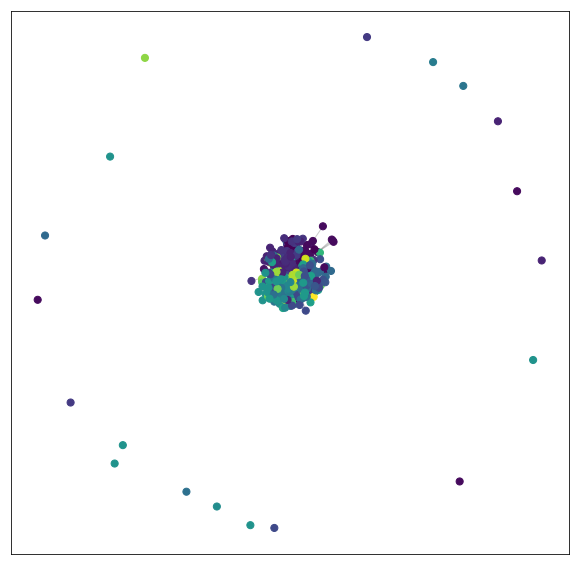

In [180]:
%matplotlib inline

def plot_graph(G, g_labels, fsize = 20, nsize = 50, show_labels = False):
    plt.figure(figsize=(fsize, fsize))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color = g_labels, node_size = nsize, with_labels = show_labels)
    nx.draw_networkx_edges(G, pos, alpha = 0.2)
    plt.show()
    
plot_graph(G, department_labels, fsize = 10)

We can see that there is multiple nodes with no connections at all. Also the isolated nodes don't seem to belong to any specific department. It might be a good idea to remove them?

The nodes that has no edges at all:
['580', '633', '648', '653', '658', '660', '670', '675', '684', '691', '703', '711', '731', '732', '744', '746', '772', '798', '808']
The departments for isolated nodes:
[ 3 21 26 17  4 14 15 22  4 30 15  9 15 23 17 21  4  4 14]


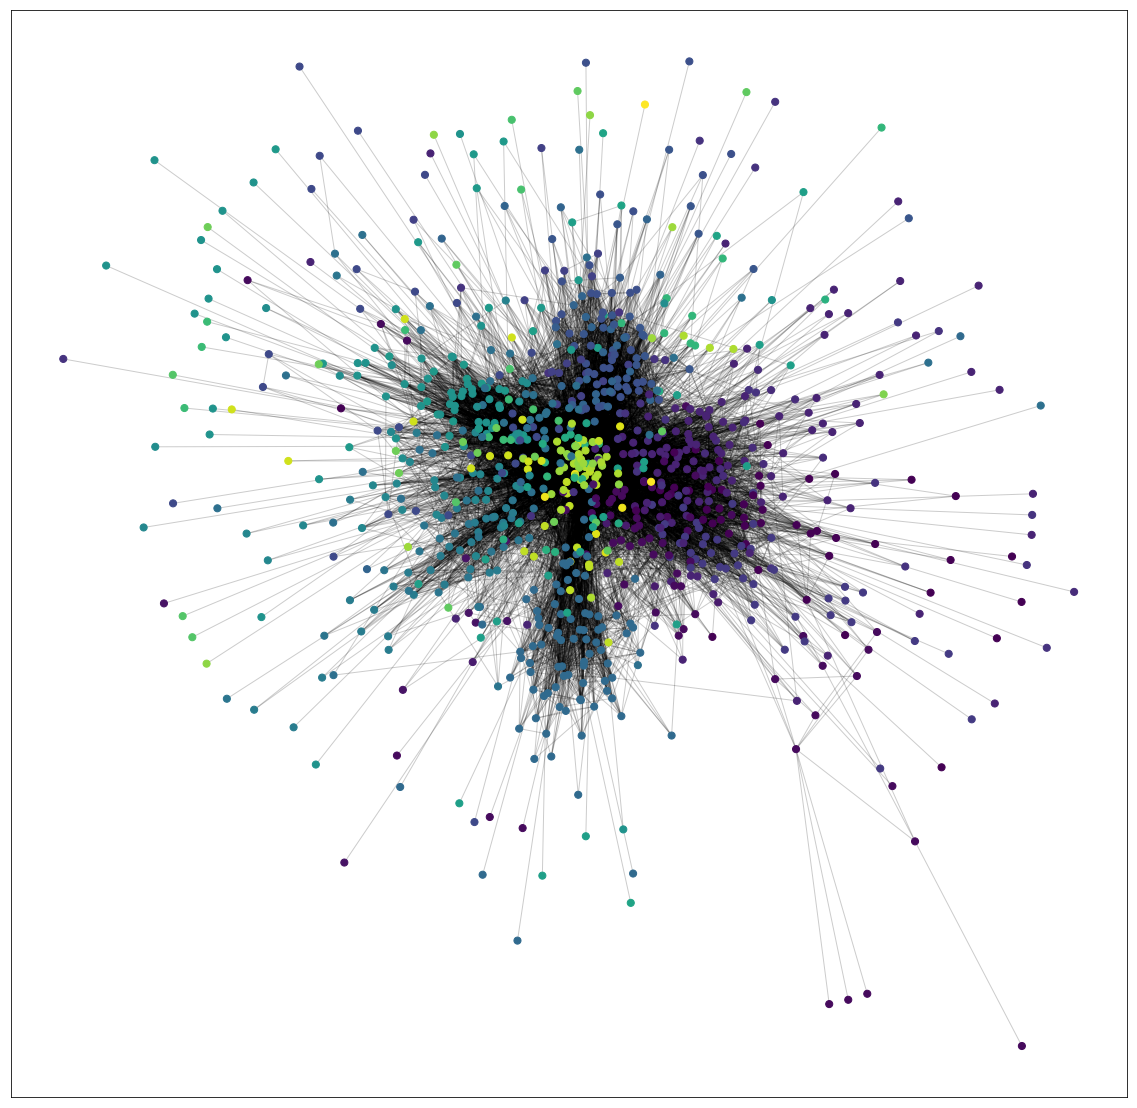

In [181]:
components = list(nx.connected_components(G))

isolated_nodes = list(nx.isolates(G))
print("The nodes that has no edges at all:")
print(isolated_nodes)

isolated_nodes_labels = labels[list(map(lambda x: int(x), isolated_nodes))]
print("The departments for isolated nodes:")
print(isolated_nodes_labels)

idx = np.ones(len(G), dtype = bool)
idx[list(map(lambda x: int(x), isolated_nodes))] = False
department_labels = department_labels[idx]
G.remove_nodes_from(isolated_nodes)

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = labels, node_size = 50)
nx.draw_networkx_edges(G, pos, alpha = 0.2)
plt.show()

General charasteristics of the graph:

In [182]:
degree_list = np.array(list(map(lambda x: x[1], list(G.degree()))))

print("Number of nodes with degree 1:")
print(len(list(filter(lambda x: x == 1, degree_list))))

print("Average degree:")
print(np.mean(degree_list))
print("Standard deviation:")
print(np.std(degree_list))
print("Degree median:")
print(np.median(degree_list))

Number of nodes with degree 1:
95
Average degree:
32.5841784989858
Standard deviation:
37.02550397234685
Degree median:
22.0


This function is for getting a subset of the network that only contains certain departments

In [124]:
def get_subgraph(G, departments):
    department_nodes = []
    for department in departments:
        l = [x for x, y in G.nodes(data = True) if y['department'] == department]
        department_nodes = department_nodes + l
    
    return G.subgraph(department_nodes)

def get_graph_labels(G):
    return list(nx.get_node_attributes(H, 'department').values())

def get_department_sizes(G):
    return [len(get_subgraph(G, [i])) for i in range(42)]


Lets calculate how many in-department edges and how many out-department edges there is for each department

In [126]:
%matplotlib inline
import pandas as pd

def get_out_department_edges(dep_i):
    department = get_subgraph(G, [dep_i])
    return np.sum(list(map(lambda n: len(list(filter(lambda x: x != dep_i, list(nx.get_node_attributes(G.subgraph(list(G.neighbors(n))), 'department').values())))), department)))

def get_in_department_edges(dep_i):
    department = get_subgraph(G, [dep_i])
    return department.number_of_edges()


Lets create a pandas dataset that show the department charasteristics:

In [142]:
import pandas as pd

nodes = np.array(get_department_sizes(G))
in_edges = np.array([get_in_department_edges(i) for i in range(42)])
out_edges = np.array([get_out_department_edges(i) for i in range(42)])
total_edges = in_edges + out_edges
average_clustering = np.array([nx.average_clustering(get_subgraph(G, [i])) for i in range(42)])
average_degree = np.array([np.mean(list(map(lambda x: x[1], G.degree(get_subgraph(G, [i]))))) for i in range(42)])
max_degree = np.array([np.max(list(map(lambda x: x[1], G.degree(get_subgraph(G, [i]))))) for i in range(42)])
min_degree = np.array([np.min(list(map(lambda x: x[1], G.degree(get_subgraph(G, [i]))))) for i in range(42)])

data = {'Department':  list(range(42)),
        'nodes': nodes,
        'in-edges': in_edges,
        'out-edges': out_edges,
        'out-edges/in-edges': np.round(out_edges / in_edges, 2),
        'edges/nodes': np.round((in_edges + out_edges) / nodes, 2),
        '% of out_edges': np.round(out_edges / (in_edges + out_edges), 2),
        'out-edges/nodes': np.round(out_edges / get_department_sizes(G), 2),
        'is-connected': [nx.is_connected(get_subgraph(G, [i])) for i in range(42)],
        '% of total edges': np.round((in_edges + out_edges) / G.number_of_edges(), 2),
        'average clustering': np.round(average_clustering, 2),
        'average degree': np.round(average_degree, 2),
        'max degree': max_degree,
        'min degree': min_degree
        }

df = pd.DataFrame (data, columns = ['Department', 'nodes', 'in-edges', 'out-edges', 'out-edges/in-edges',
                                    'edges/nodes', '% of out_edges', 'out-edges/nodes', 'is-connected', 
                                    '% of total edges', 'average clustering', 'average degree', 'max degree', 
                                    'min degree'])


print(df)


    Department  nodes  in-edges  out-edges  out-edges/in-edges  edges/nodes  \
0            0     49       292        661                2.26        19.45   
1            1     65       368        972                2.64        20.62   
2            2     10        31        172                5.55        20.30   
3            3     12        36        234                6.50        22.50   
4            4    109       813       1889                2.32        24.79   
5            5     18       103        562                5.46        36.94   
6            6     28        33        368               11.15        14.32   
7            7     51       473        683                1.44        22.67   
8            8     19        99        424                4.28        27.53   
9            9     32       107        470                4.39        18.03   
10          10     39       324        874                2.70        30.72   
11          11     29       227        581          

/home/matleino/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


Lets calculate and plot the degree centralities for nodes in different departments:

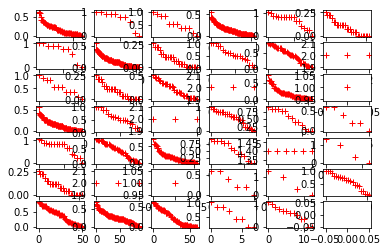

In [148]:
from operator import itemgetter

for i in range(42):
    F = get_subgraph(G, [i])
    degc = nx.degree_centrality(F)
    

figure, axes = plt.subplots(nrows=7, ncols=6)
for i in range(7):
    for j in range(6):
            F = get_subgraph(G, [(i + 1) * (j + 1)])
            degc = nx.degree_centrality(F)
            data = np.array(sorted(list(degc.values()), reverse = True))

            axes[i, j].plot(data, 'r+')

plt.show()


This function returns a subset with out department nodes as one node. Below is an example of a department subgraph with all edges to outside departments connecting to node.

{'175': Text(0.3986852239885619, 0.3716581063572314, '175'),
 '991': Text(-0.5956969538008333, 0.3488191848103928, '991'),
 '665': Text(-0.05863442668957429, 0.3284098194661828, '665'),
 '886': Text(0.3173383913644477, -0.2582613038389473, '886'),
 '9999': Text(-1.0956969538008332, -1.5, '9999'),
 '971': Text(0.022373113345315932, -0.10750425365907924, '971'),
 '888': Text(-0.2690382024201603, -1.0, '888'),
 '859': Text(0.06614645006109109, 0.205897796187376, '859'),
 '174': Text(0.23119229907284927, 0.04953412436874572, '174'),
 '812': Text(-0.15583048354564516, 0.012006706551308687, '812')}

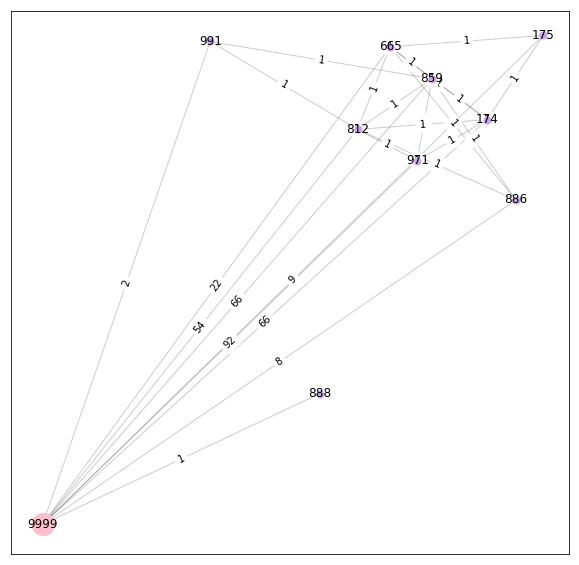

In [158]:
def get_node_attribute(G, n):
    return list(nx.get_node_attributes(G.subgraph(n), 'department').values())[0]

def get_subgraph_with_out_edges(G, dep_i):
    department = get_subgraph(G, [dep_i]).copy()
    for e in department.edges():
        department.add_edge(*e, weight = 1)
    
    department.add_node('9999')
    nx.set_node_attributes(department, {'9999': '9999'}, 'department')
    
    for n in department:
        if (n != '9999'):
            n_neighbors = list(G.neighbors(n))
            not_in_same_dep = list(filter(lambda x: get_node_attribute(G, x) != get_node_attribute(G, n), n_neighbors))
            len_not_in_same_dep = len(not_in_same_dep)
            if len_not_in_same_dep > 0:
                department.add_edge(n, '9999', weight = len_not_in_same_dep)
        
    return department

i = 32
dep = get_subgraph_with_out_edges(G, i)


plt.figure(figsize=(10, 10))
pos = nx.spring_layout(dep)
pos['9999'] = [np.min(list(map(lambda x: x[0], pos.values()))) - 0.5, np.min(list(map(lambda x: x[1], pos.values())))- 0.5]

nx.draw_networkx_nodes(dep, pos, nodelist = {'9999'}, node_size = 500, node_color='pink')
nx.draw_networkx_nodes(dep, pos, nodelist = set(dep) - {'9999'}, node_size = 50, node_color = '#caa6ed')

nx.draw_networkx_edges(dep, pos, alpha = 0.2)
labels = nx.get_edge_attributes(dep, 'weight')
nx.draw_networkx_edge_labels(dep, pos, edge_labels = labels)

nx.draw_networkx_labels(dep, pos, labels = {n: n for n in set(dep)})


Lets compute and plot the number of out-edges for nodes in each department:

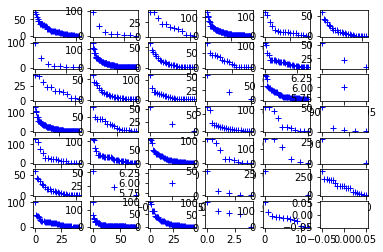

In [188]:
figure, axes = plt.subplots(nrows=7, ncols=6)
for i in range(7):
    for j in range(6):
        F = get_subgraph_with_out_edges(G, (i + 1) * (j + 1))
        weights = dict()
        for n in F:
            if (F.has_edge(n, '9999')):
                weights[n] = F.get_edge_data(str(n), '9999')['weight']

        data = sorted(list(weights.values()), reverse = True)
        axes[i, j].plot(data, 'b+')

plt.show()

Lets try the Girvan-Newman algorithm for the whole graph:

Community 0
Community 1
Community 2


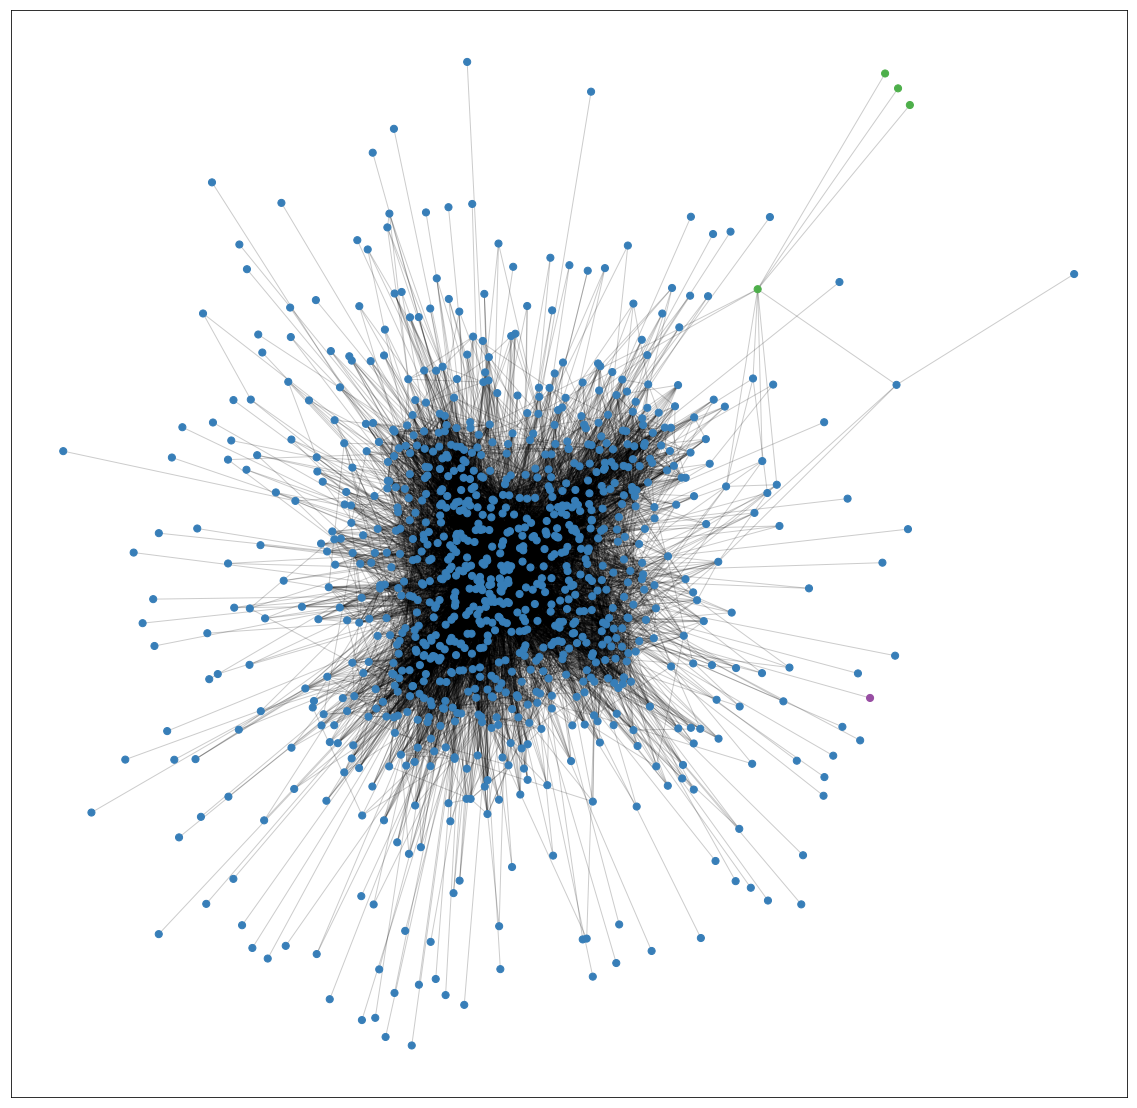

In [187]:
%matplotlib inline

from random import random
from itertools import islice
from matplotlib import cm

def most_valuable_edge(G):
    centrality = nx.edge_betweenness_centrality(G)
    max_cent = max(centrality.values())
    centrality = {e: c / max_cent for e, c in centrality.items()}
    centrality = {e: c + random() for e, c in centrality.items()}
    return max(centrality, key=centrality.get)

def get_labels_from_girvan_newman(G):
    gn_generator = nx.algorithms.community.centrality.girvan_newman(G, most_valuable_edge)
    num_iter = 1
    gn_communities = next(islice(gn_generator, num_iter, None))

    gn_dict_communities = {}

    for i, c in enumerate(gn_communities):
        print ("Community {}".format(i))
        for node in c:
            gn_dict_communities[node] = i + 1

    for node in G:
        if node not in gn_dict_communities.keys():
            gn_dict_communities[node] = -1
        
    gn_colors = []
    for node in G.nodes:
        gn_colors.append(cm.Set1(gn_dict_communities[node]))
        
    return gn_colors
    
gn_pos = nx.spring_layout(G)
gn_labels = get_labels_from_girvan_newman(G)
    

plot_graph(G, gn_labels)

We can see that the Girva-Newman algorithm doesn't work very well for the whole graph. Lets try to find communities for a subgraph of a couple departments.

Community 0
Community 1
Community 2


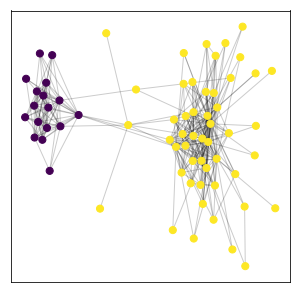

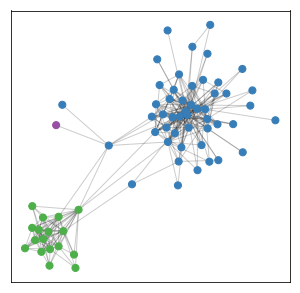

In [154]:
deps = [5, 15]
H = get_subgraph(G, deps)
# get largest component
H = H.subgraph(list(list(nx.connected_components(H))[0]))

#H_labels = labels[list(map(lambda x: int(x), list(H.nodes)))]
H_labels = list(nx.get_node_attributes(H, 'department').values())
gn_colors = get_labels_from_girvan_newman(H)

plot_graph(H, H_labels, 5)
plot_graph(H, gn_colors, 5)

Finding communities with Louvain algorithm:

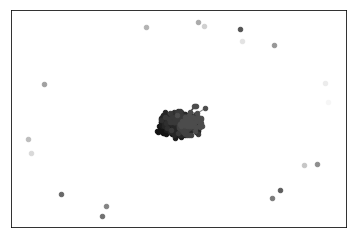

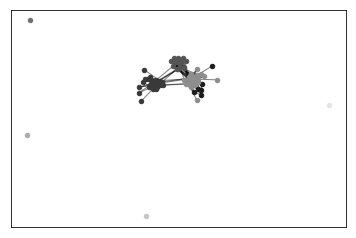

[0 1 2 3 4 5 6 7 8]
louvain label = 0, real label = 10
louvain label = 0, real label = 10
louvain label = 0, real label = 17
louvain label = 0, real label = 5
louvain label = 0, real label = 17
louvain label = 0, real label = 17
louvain label = 0, real label = 17
louvain label = 0, real label = 17
louvain label = 1, real label = 17
louvain label = 1, real label = 10
louvain label = 1, real label = 10
louvain label = 1, real label = 5
louvain label = 1, real label = 10
louvain label = 1, real label = 5
louvain label = 1, real label = 10
louvain label = 1, real label = 17
louvain label = 1, real label = 17
louvain label = 1, real label = 5
louvain label = 1, real label = 10
louvain label = 1, real label = 5
louvain label = 1, real label = 10
louvain label = 1, real label = 17
louvain label = 1, real label = 10
louvain label = 1, real label = 10
louvain label = 1, real label = 10
louvain label = 1, real label = 10
louvain label = 1, real label = 17
louvain label = 1, real label = 10
louva

In [150]:
import community 

def draw_louvain_plot(G, partition):
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = str(count / size))

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

partition = community.best_partition(G)
draw_louvain_plot(G, partition)

deps = [5, 10, 17]
H = get_subgraph(G, deps)
partition = community.best_partition(H)
draw_louvain_plot(H, partition)


louvain_labels = np.array(list(partition.values()))

z = list(zip(H_labels, louvain_labels))
z2 = sorted(z, key=lambda tup: tup[1])
for tup in z2:
    print('louvain label = {}, real label = {}'.format(tup[1], tup[0]))
